# COGS 108 - EDA Checkpoint

# Names

- Roger Deng
- Yutong Guo
- Yuchen Jiang
- Junren Le
- Miki Sze To

# Research Question

In the Bitcoin market, how can traditional financial indicators combined with data science techniques be effectively used to develop a predictive model designed to provide investors with more accurate predictions in order to make more informed investment decisions when buying (going long) or selling (going short) Bitcoin?

# Dataset(s)

- Dataset Name: df_btc
- Link to the dataset: use Binance API to generate from "1 Jan, 2022" up to "31 Dec, 2022".
- Number of observations: 8737

This dataset was generated using the Binance API (in read-only mode) from "1 Jan, 2022" up to "31 Dec, 2022". This enables our model to remain up-to-date and provide practical insights to assist with trading decisions.

# Setup

In [1]:
# import pandas & numpy library
# use pandas for data structure and data analysis, and numpy for numerical computation
import pandas as pd
import numpy as np

# import matplotlib & seaborn & plotly library
# used for creating data visualization charts
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# import binance library
# used for interacting with the Binance exchange API to obtain trading data
from binance.client import Client

# import ta library
import ta

# improve resolution
%config InlineBackend.figure_format ='retina'

In [2]:
# Set up API connection to Binance exchange
# API is set to the read-only mode for security
# VPN outside of the United States is necessary to access the most complete data from Binance Global
api_key = "DGtRGRqVFIzlxxMZ6A31XzZMkvtUpgPtNMSzOxroRFidSrNEUFbeZspZcxCfPg3D"
api_secret = "e6obJUVaRaBgF44rYiRolvfgb4EcwWlyVwLMeTl7Jy52ixtFGF9F2WICRguwKIJ"

# ‘client' is used to interact with the Binance API, making requests for historical trading data
client = Client(api_key, api_secret)

# Data Cleaning

Based on one of the binance API documents: https://github.com/binance/binance-public-data/#klines,
we are able to understand that the kline data we generated would have following columns:
- Open time
- Open
- High
- Low
- Close
- Volume
- Close time
- Quote asset volume
- Number of trades
- Taker buy base asset volume
- Taker buy quote asset volume
- Ignore
To simply the analysis of the price trends and allow us to focus on the most basic and important information needed, we would select the first six columns to help build the model:
- Open time
- Open
- High
- Low
- Close
- Volume

In [3]:
# Define ‘get_historical_data' function
# parameters: symbol (trading pair), interval (time interval), start (start time), end(end time)
# we use the Biance client object's 'get_historical_klines' method to obtain historical K-line
# return a DataFrame, it will include:
#‘timestamp’,represents the time of trading data 
#'open',the opening price
#'high',the highest trading price
#'low',the lowest trading price 
#'close',the closing price 
#'volume', the trading volume
def get_historical_data(symbol, interval, start, end):
    klines = client.get_historical_klines(symbol, interval, start, end)
    df = pd.DataFrame(klines)

    # drop unnecessary columns
    df.drop([6,7,8,9,10,11], axis=1, inplace=True)

    # name the columns for the DataFrame
    df.columns = ["timestamp", "open", "high", "low", "close", "volume"]

    # Convert the 'timestamp' to pandas datatime type
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df[["open", "high", "low", "close", "volume"]] = df[["open", "high", "low", "close", "volume"]].astype(float)

    # set the 'timestamp' as index of the dataframe
    df.set_index("timestamp", inplace=True)
    return df

In [4]:
# Assign the historical data with 1 hour interval
# The data range is set to be from "1 Jan, 2022" up to "31 Dec, 2022"
df_btc = get_historical_data("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "1 Jan, 2022", "31 Dec, 2022")
df_btc

open      high       low     close      volume
timestamp                                                              
2022-01-01 00:00:00  46216.93  46731.39  46208.37  46656.13  1503.33095
2022-01-01 01:00:00  46656.14  46949.99  46574.06  46778.14   943.81539
2022-01-01 02:00:00  46778.14  46928.94  46721.96  46811.77   485.16860
2022-01-01 03:00:00  46811.77  46916.63  46760.12  46813.20   562.88971
2022-01-01 04:00:00  46813.21  46887.33  46591.23  46711.05   861.88389
...                       ...       ...       ...       ...         ...
2022-12-30 20:00:00  16525.91  16571.51  16523.91  16568.69  6253.72281
2022-12-30 21:00:00  16569.36  16677.35  16568.31  16585.06  8873.19505
2022-12-30 22:00:00  16585.06  16597.00  16577.57  16583.27  3950.19324
2022-12-30 23:00:00  16582.81  16618.75  16568.00  16607.48  4986.34147
2022-12-31 00:00:00  16607.48  16616.37  16578.00  16580.32  4264.25848

[8737 rows x 5 columns]

In [5]:
# Observe the first few rows of the dataset
df_btc.head()

open      high       low     close      volume
timestamp                                                              
2022-01-01 00:00:00  46216.93  46731.39  46208.37  46656.13  1503.33095
2022-01-01 01:00:00  46656.14  46949.99  46574.06  46778.14   943.81539
2022-01-01 02:00:00  46778.14  46928.94  46721.96  46811.77   485.16860
2022-01-01 03:00:00  46811.77  46916.63  46760.12  46813.20   562.88971
2022-01-01 04:00:00  46813.21  46887.33  46591.23  46711.05   861.88389

In [6]:
# Observe the shape of the dataset
df_btc.shape

(8737, 5)

Through this code, we obtained the dimensions of the DataFrame(df_btc), which contains 8,737 rows and 5 columns. In other words, this DataFrame has 8,737 data points (or observations) and includes 5 variables ('open','high','low','close','volume').


In [7]:
# Explore the statistics of the entire dataset
df_btc.describe()

open          high           low         close         volume
count   8737.000000   8737.000000   8737.000000   8737.000000    8737.000000
mean   28258.624938  28390.457379  28122.898130  28255.232305    6105.181286
std    10188.619716  10237.442983  10137.491133  10187.576637    6479.086651
min    15648.230000  15769.990000  15476.000000  15649.520000     240.245560
25%    19535.190000  19635.560000  19467.390000  19534.210000    1632.343230
50%    23170.320000  23253.390000  23066.040000  23170.280000    4318.628690
75%    39017.190000  39196.510000  38831.730000  39017.190000    8260.132890
max    47970.980000  48189.840000  47811.400000  47970.990000  137207.188600

This summary provides key descriptive statistics for each of the variables (open, high, low, close, and volume). It includes the count, mean, standard deviation, minimum, 25th percentile, 50th percentile (median), 75th percentile, and maximum for each variable.

Data Completeness: The 'count' value indicates that all variables (open, high, low, close, and volume) have 8,737 observations, which implies that there are no missing data points.

Data Distribution: By looking at the mean and median (50% percentile), we can understand the central tendency of the data. If the mean and median are close, the data might be normally distributed; if they differ significantly, there might be skewness.

Data Volatility: Through the standard deviation (std), we can comprehend the degree of fluctuation for each variable. A higher standard deviation indicates a more widespread distribution of data, while a lower one implies that the data is concentrated around the mean.

Data Range: The minimum (min) and maximum (max) values describe the overall range of the data. This helps us understand the extreme cases of the data and possible outliers.

Quartiles: The 25% and 75% percentiles represent the interquartile range of the data. This can help us understand the shape and dispersion of the data distribution.

In [8]:
# Create a new Plotly Figure object and use Candlestick chart data to do it.
# x-axis uses timestamps, and the other data uses the opening price, highest price. lowest price and closing price from the 'df_btc' DataFrame
fig = go.Figure(data=[go.Candlestick(x=df_btc.index,
                open=df_btc['open'],
                high=df_btc['high'],
                low=df_btc['low'],
                close=df_btc['close'])])

# setting the chart title, x-axis title, and y-axis title
fig.update_layout(title='Bitcoin Price Chart',
                   xaxis_title='Date',
                   yaxis_title='Price (USDT)')

fig.show()

MACD (Moving Average Convergence Divergence) is a technical indicator used to identify potential buying and selling opportunities in financial markets. It is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA, and then plotting a 9-period EMA on top of the MACD line. The resulting plot can be used to identify trend reversals, momentum shifts, and potential buy/sell signals.

By creating a function add_macd that will take a given DataFrame of stock price of as its input, return modified DataFrame as its output.

Calculate the exponential moving averages (EMA) of the stock's closing price over the last 12 and 26 periods by using .ewm() and .mean() functions. Store them in the 'ema12' and 'ema26' columns of the dataframe 'df'.

MACD Line('macd'): ('ema12' - 'ema26') Signal Line('signal'): 9-day EMA of MACD Line MACD Histogram: MACD Line - Signal Line

# Data Analysis & Results (EDA)

In [9]:
# Add MACD indicator
def add_macd(df):
    df['ema12'] = df['close'].ewm(span=12).mean()
    df['ema26'] = df['close'].ewm(span=26).mean()
    df['macd'] = df['ema12'] - df['ema26']
    df['signal'] = df['macd'].ewm(span=9).mean()
    return df

The BIAS (Buy and Sell) indicator calculates the difference between an asset's current closing price and its n-period moving average. It is a momentum indicator that indicates if an asset is oversold or overbought. Based on the divergence between the current price and its moving average, the BIAS indicator is utilized to identify probable market entry or exit positions.

By creating a function add_bias that will take a given DataFrame of stock price df and an optional integer ‘period’ as its input, return modified DataFrame as its output.

BIAS indicator （‘bias_period ’）= （closing price - rolling mean of‘period’）/（rolling mean of‘period’）*100

In [10]:
# Add BIAS indicator
def add_bias(df, period=12):
    df[f'bias_{period}'] = (df['close'] - df['close'].rolling(window=period).mean()) / df['close'].rolling(window=period).mean() * 100
    return df

The Relative Strength Index (RSI) is a technical indicator that assesses whether an asset is overbought or oversold by measuring the size of recent price changes. The RSI is a 14-period oscillator with a range of 0 to 100. (e.g. 14 days, 14 hours, etc.). Values more than 70 are regarded overbought, while values less than 30 are considered undersold.

The function add_rsi takes a DataFrame of stock price data and 'period' as input and calculates the RSI indicator using the stock's closing prices. Store the change in price between the current and previous period in variable 'delta', separates the gains and losses into two separate columns 'gain' and 'loss'. Calculates the average gain and loss over a specified period using the rolling.() and mean.() functions.

RS = Average Gain('avg_gain') / Average Loss('avg_loss') RSI = 100 - (100 / (1 + RS))

In [11]:
# Add RSI indicator
def add_rsi(df, period=14):
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))
    return df

The Bollinger Bands is a technical indicator that measures the volatility of the market and overbought and oversold conditions. It is made up of three lines - a simple moving average (SMA) that represents the middle band, and upper and lower bands that are typically set two standard deviations away from the middle band. As the volatility of the market increases or decreases, the distance between the upper and lower bands increases or decreases accordingly.

UPPER_BB('upper') = STOCK SMA + SMA STANDARD DEVIATION * 2 UPPER_BB('lower')B = STOCK SMA - SMA STANDARD DEVIATION * 2

In [12]:
# Add Bollinger Bands indicator
def add_boll(df, period=20, std=2):
    df['middle'] = df['close'].rolling(window=period).mean()
    df['upper'] = df['middle'] + df['close'].rolling(window=period).std() * std
    df['lower'] = df['middle'] - df['close'].rolling(window=period).std() * std
    return df

In [13]:
# Apply indicators to the dataframe
df_btc = add_macd(df_btc)
df_btc = add_bias(df_btc)
df_btc = add_rsi(df_btc)
df_btc = add_boll(df_btc)

In [14]:
df_btc

open      high       low     close      volume  \
timestamp                                                                 
2022-01-01 00:00:00  46216.93  46731.39  46208.37  46656.13  1503.33095   
2022-01-01 01:00:00  46656.14  46949.99  46574.06  46778.14   943.81539   
2022-01-01 02:00:00  46778.14  46928.94  46721.96  46811.77   485.16860   
2022-01-01 03:00:00  46811.77  46916.63  46760.12  46813.20   562.88971   
2022-01-01 04:00:00  46813.21  46887.33  46591.23  46711.05   861.88389   
...                       ...       ...       ...       ...         ...   
2022-12-30 20:00:00  16525.91  16571.51  16523.91  16568.69  6253.72281   
2022-12-30 21:00:00  16569.36  16677.35  16568.31  16585.06  8873.19505   
2022-12-30 22:00:00  16585.06  16597.00  16577.57  16583.27  3950.19324   
2022-12-30 23:00:00  16582.81  16618.75  16568.00  16607.48  4986.34147   
2022-12-31 00:00:00  16607.48  16616.37  16578.00  16580.32  4264.25848   

                            ema12         ema26       macd     signal  \
timestamp                                                               
2022-01-01 00:00:00  46656.130000  46656.130000   0.000000   0.000000   
2022-01-01 01:00:00  46722.218750  46719.481346   2.737404   1.520780   
2022-01-01 02:00:00  46757.170624  46752.639763   4.530860   2.754419   
2022-01-01 03:00:00  46774.856908  46769.569759   5.287149   3.612390   
2022-01-01 04:00:00  46757.520799  46755.998786   1.522014   2.990550   
...                           ...           ...        ...        ...   
2022-12-30 20:00:00  16533.326036  16546.476530 -13.150494 -21.765748   
2022-12-30 21:00:00  16541.285107  16549.334565  -8.049457 -19.022490   
2022-12-30 22:00:00  16547.744322  16551.848301  -4.103979 -16.038788   
2022-12-30 23:00:00  16556.934426  16555.969167   0.965259 -12.637978   
2022-12-31 00:00:00  16560.532207  16557.772933   2.759274  -9.558528   

                      bias_12        rsi      middle         upper  \
timestamp                                                            
2022-01-01 00:00:00       NaN        NaN         NaN           NaN   
2022-01-01 01:00:00       NaN        NaN         NaN           NaN   
2022-01-01 02:00:00       NaN        NaN         NaN           NaN   
2022-01-01 03:00:00       NaN        NaN         NaN           NaN   
2022-01-01 04:00:00       NaN        NaN         NaN           NaN   
...                       ...        ...         ...           ...   
2022-12-30 20:00:00  0.330100  52.321195  16533.5090  16639.751431   
2022-12-30 21:00:00  0.394854  62.024238  16532.3305  16635.544096   
2022-12-30 22:00:00  0.336158  59.556200  16531.2910  16631.847421   
2022-12-30 23:00:00  0.426327  60.219168  16531.7110  16633.521927   
2022-12-31 00:00:00  0.218789  60.402425  16530.0375  16627.160123   

                            lower  
timestamp                          
2022-01-01 00:00:00           NaN  
2022-01-01 01:00:00           NaN  
2022-01-01 02:00:00           NaN  
2022-01-01 03:00:00           NaN  
2022-01-01 04:00:00           NaN  
...                           ...  
2022-12-30 20:00:00  16427.266569  
2022-12-30 21:00:00  16429.116904  
2022-12-30 22:00:00  16430.734579  
2022-12-30 23:00:00  16429.900073  
2022-12-31 00:00:00  16432.914877  

[8737 rows x 14 columns]

Plot of the Moving Average Convergence Divergence (MACD) and Signal Line of a cryptocurrency's historical prices.

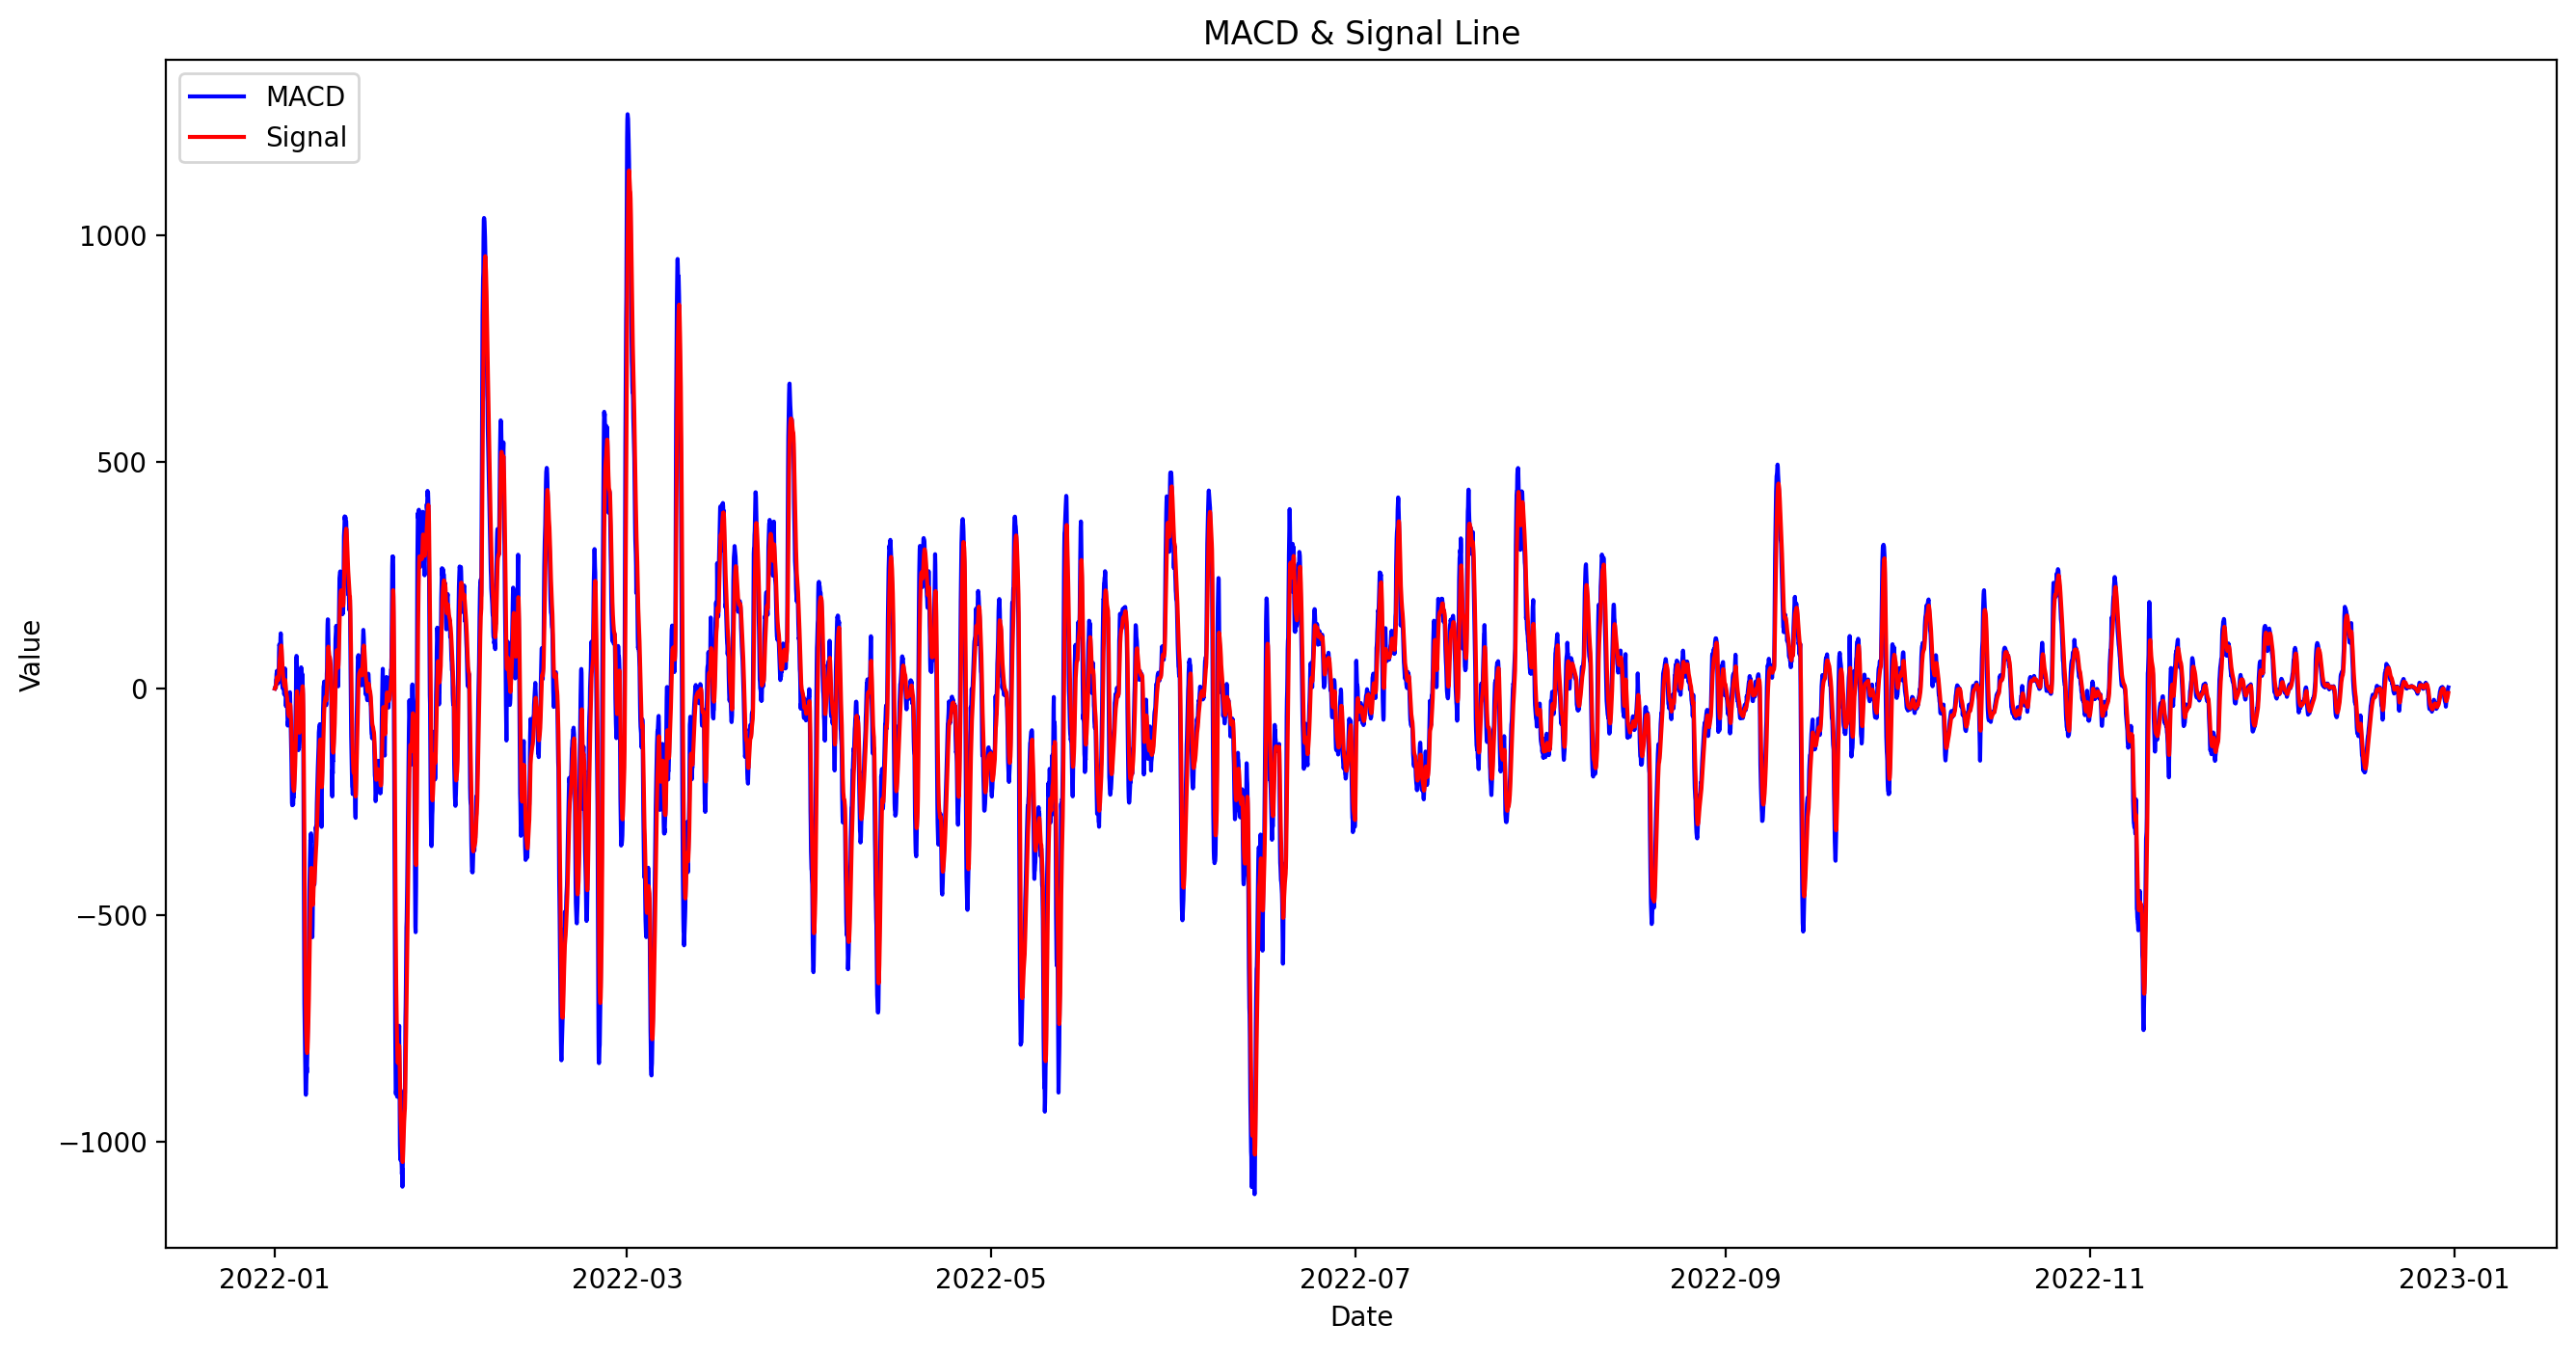

In [15]:
# Plot MACD
plt.figure(figsize=(16, 8))
plt.plot(df_btc.index, df_btc['macd'], label='MACD', color='blue')
plt.plot(df_btc.index, df_btc['signal'], label='Signal', color='red')
plt.legend(loc='upper left')
plt.title('MACD & Signal Line')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

MACD above zero is considered bullish, while below zero is bearish. Additionally, when MACD rises from below zero, it is considered bullish, while when it falls from above zero, it is seen as bearish. When the MACD line crosses above the signal line from below, the indicator is considered bullish. The lower it is below the zero line, the stronger the signal. When the MACD line crosses below the signal line from above, the indicator is considered bearish. The farther it is from the zero line, the stronger the signal.

Plot of the BIAS (12-period) values are plotted against the dates of the Bitcoin prices.

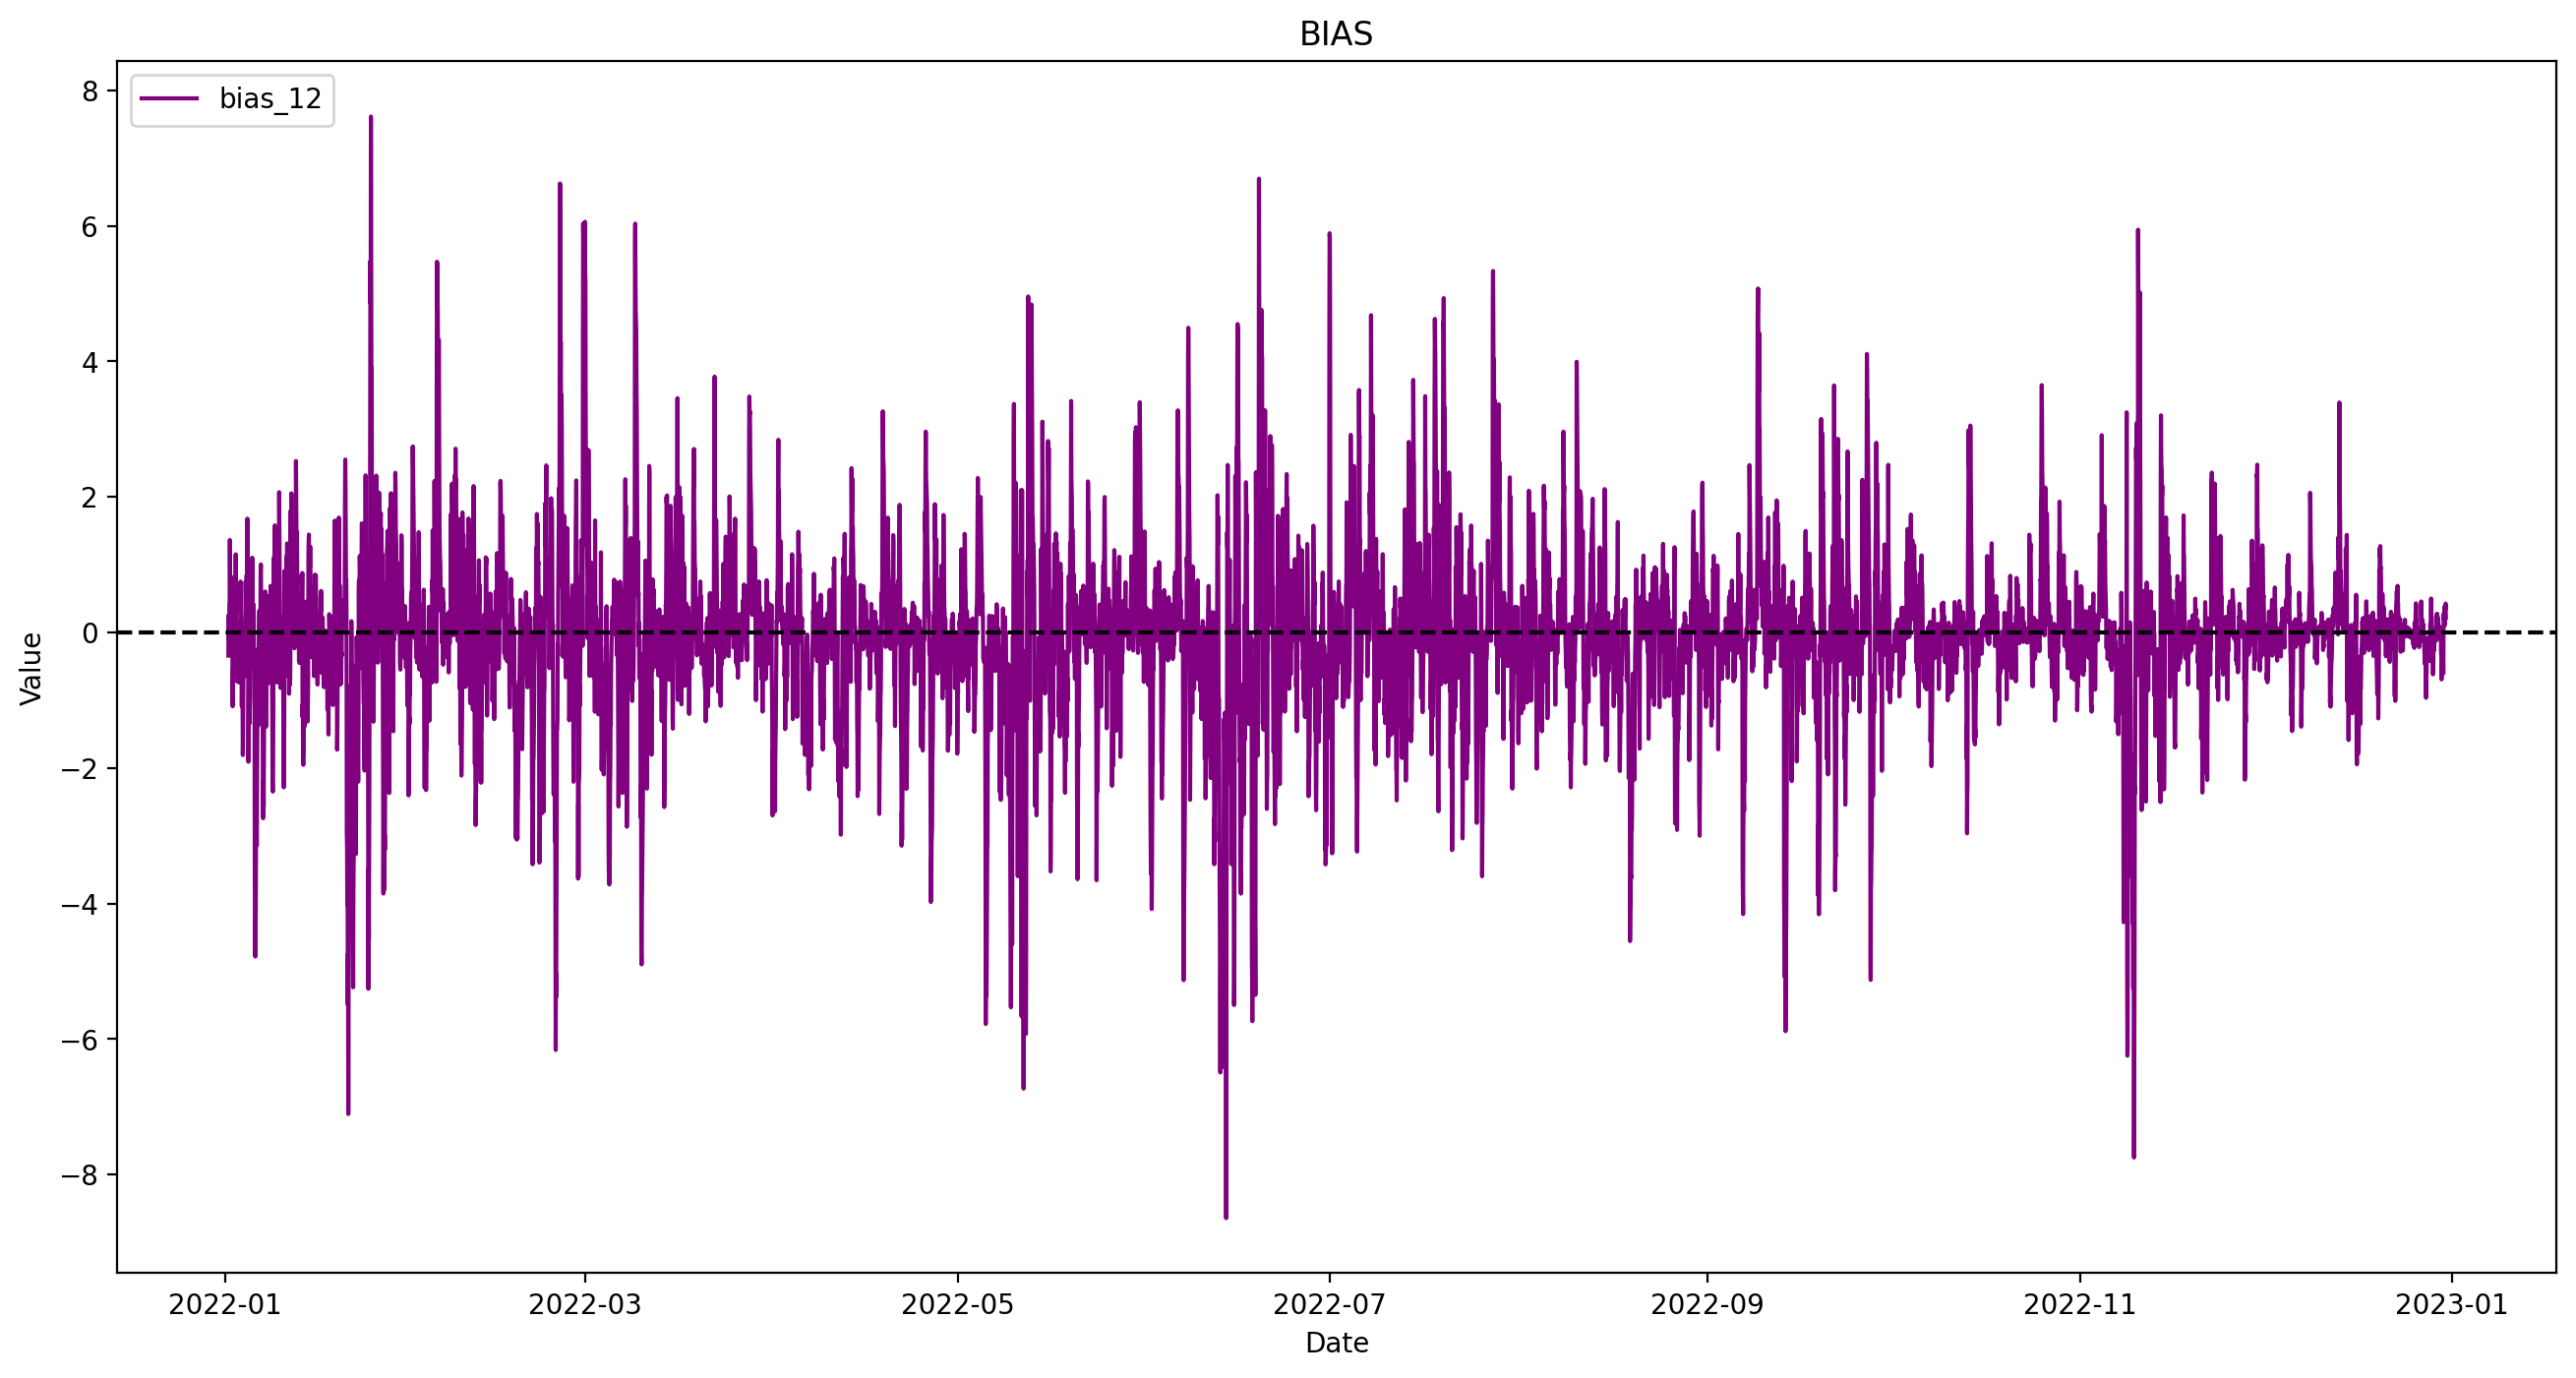

In [16]:
# Plot BIAS
plt.figure(figsize=(16, 8))
plt.plot(df_btc.index, df_btc['bias_12'], label='bias_12', color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend(loc='upper left')
plt.title('BIAS')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

This indicator is composed of three curves, each representing a BIAS line of different periods. The shorter the BIAS line, the faster it fluctuates. When the indicator is greater than 0, it indicates that the price is above the moving average line; when the indicator is less than 0, it indicates that the price is below the moving average line.

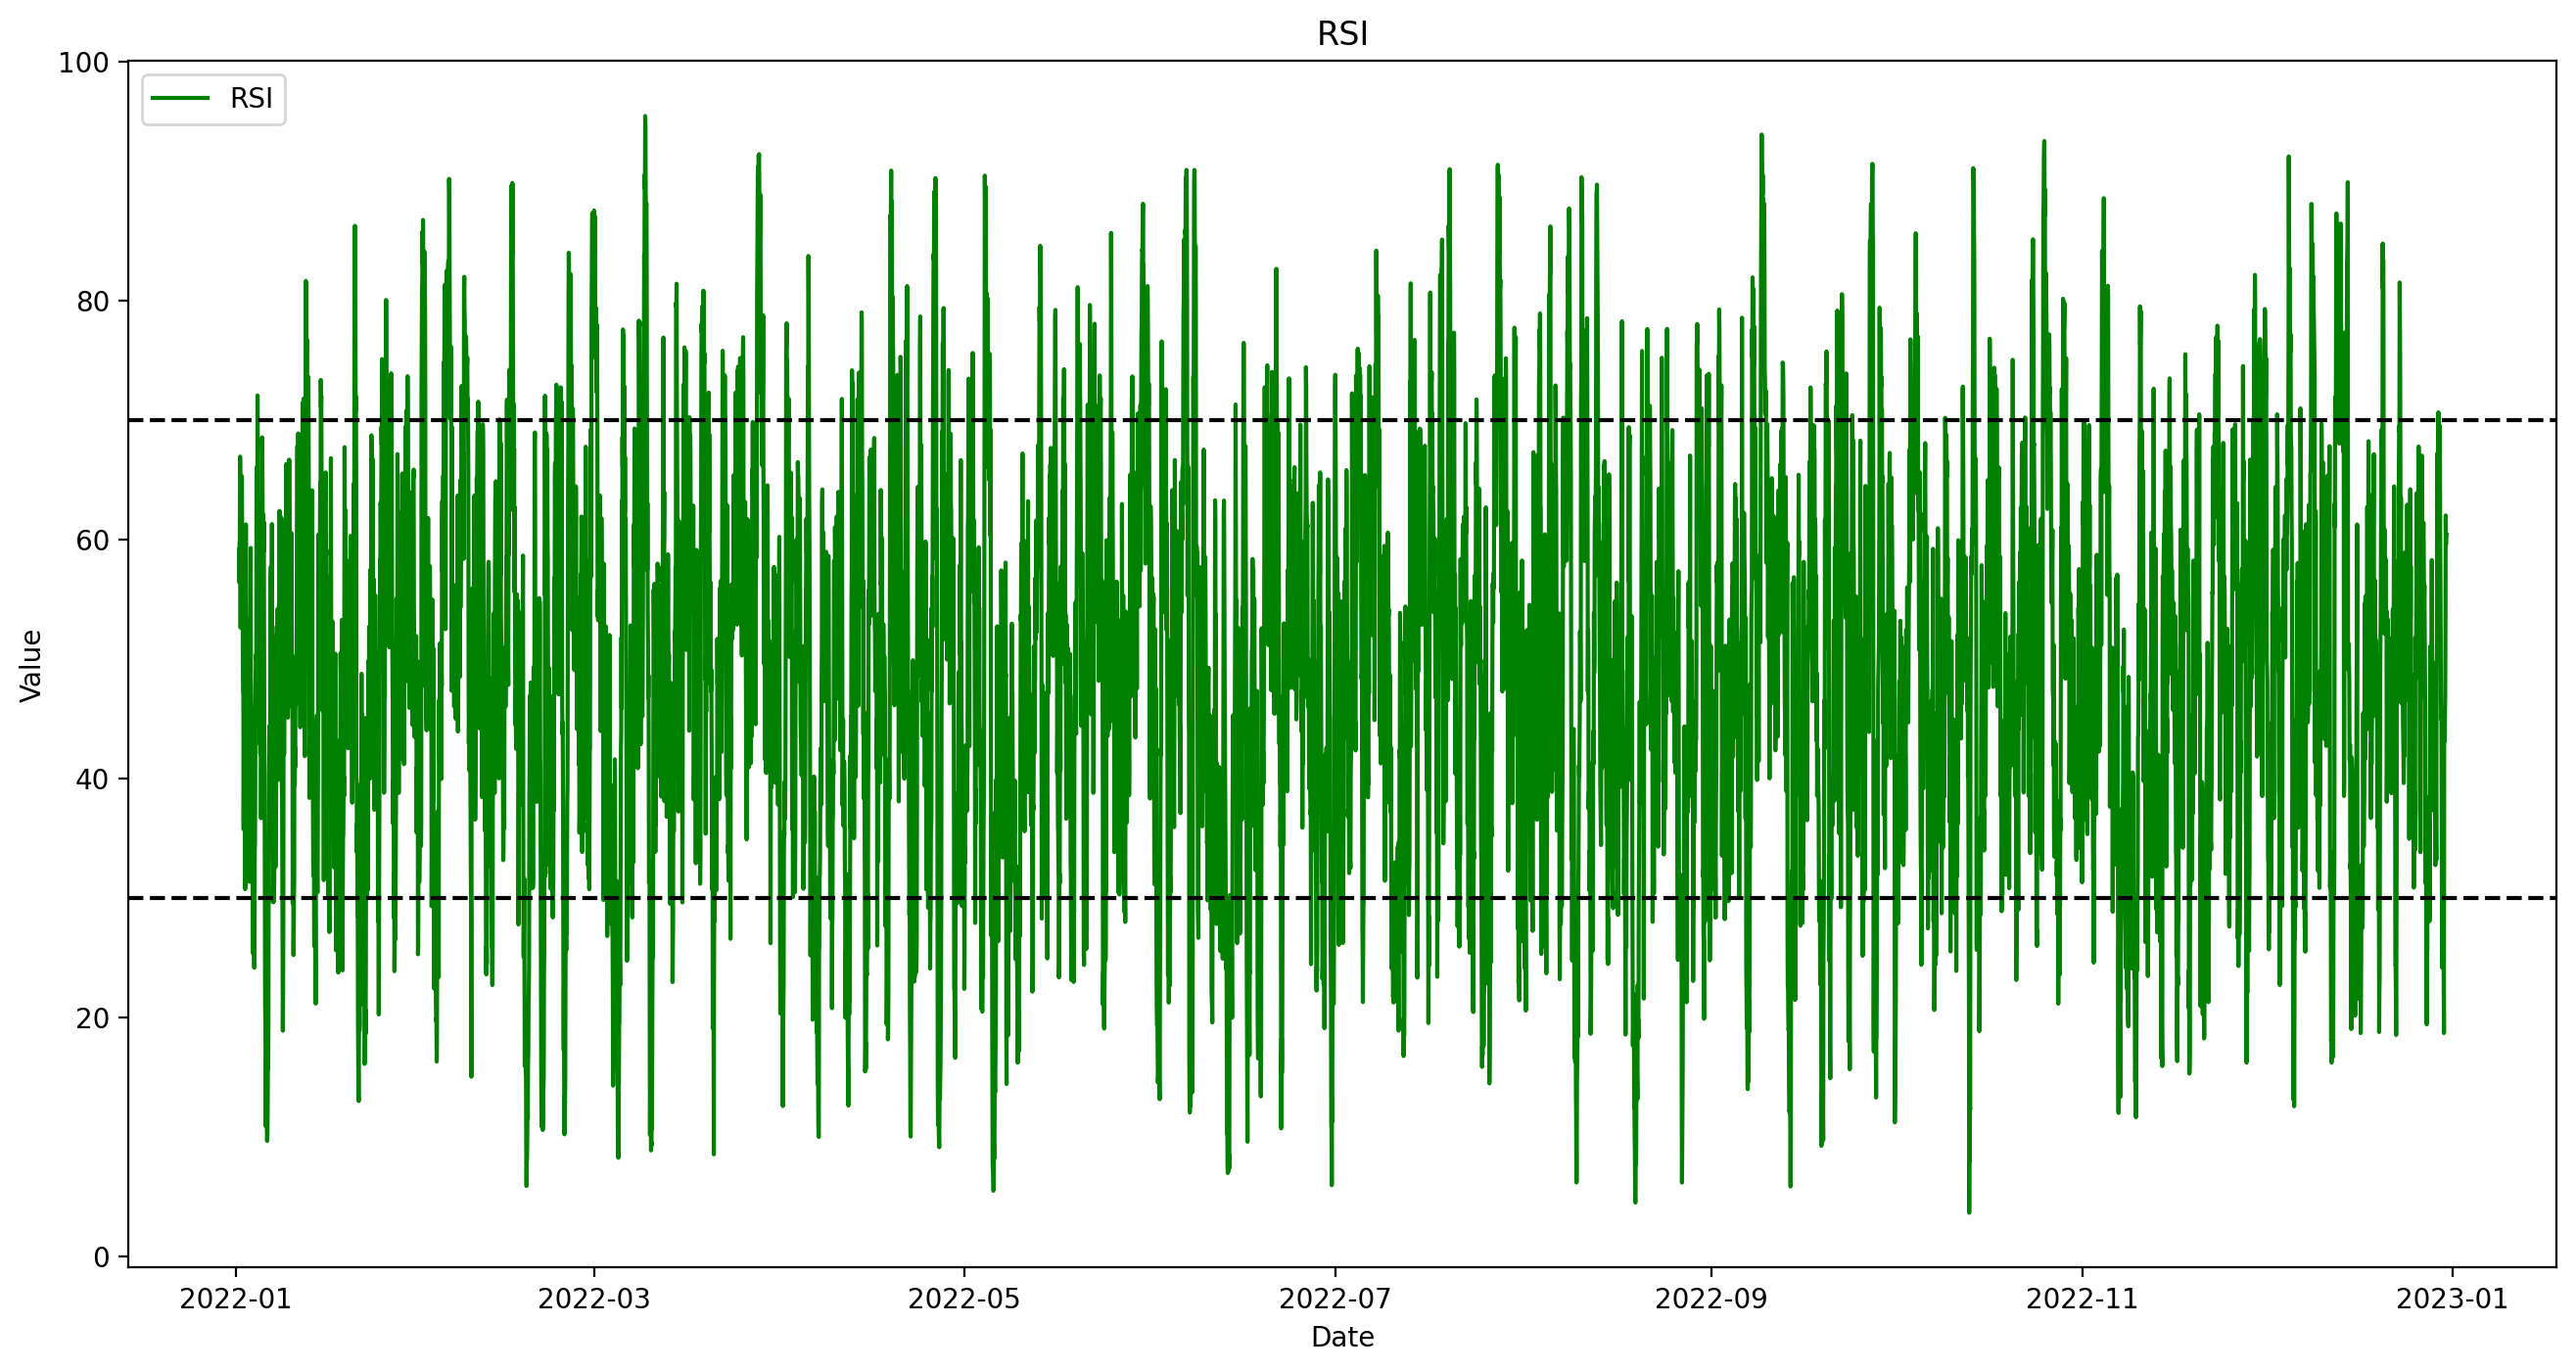

In [17]:
# Plot RSI
plt.figure(figsize=(16, 8))
plt.plot(df_btc.index, df_btc['rsi'], label='RSI', color='green')
plt.axhline(y=30, color='black', linestyle='--')
plt.axhline(y=70, color='black', linestyle='--')
plt.legend(loc='upper left')
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

Our purpose here is to plot the RSI (relative strength index) indicator. We used the RSI indicator to analyze 
the speed and magnitude of Bitcoin’s price changes. 

We used the plot() function to plot the RSI indicator as an oscillator. The data we are using is our dataset, 
df_btc. We set the overbought threshold as 70 and set the oversold threshold as 30, which are standard thresholds. 

The RSI indicator may seem a bit squished, but that is because our dataset consists of one year worth of data. 
Using this plot, we can gain valuable insights about when to buy and when to sell our Bitcoin. When the Bitcoin 
prices go above 70, it is considered overbought. When it goes down to below 30, it is considered oversold. When 
the asset is overbought, it means that the price is beyond its true value, and we expect a price correction soon, 
so that is a sign to sell the Bitcoin. On the other hand, when the asset is oversold, it means the asset is 
trading at a lower price than it should be, and we expect a price correction soon, so that is a sign to buy the 
Bitcoin. 

From our graph, we can see that a common time period that Bitcoin is oversold is the start of January, March, May, July, and September. A common time period that Bitcoin is overbought is the middle of the start of February, April, June, August, October, November, and December. 


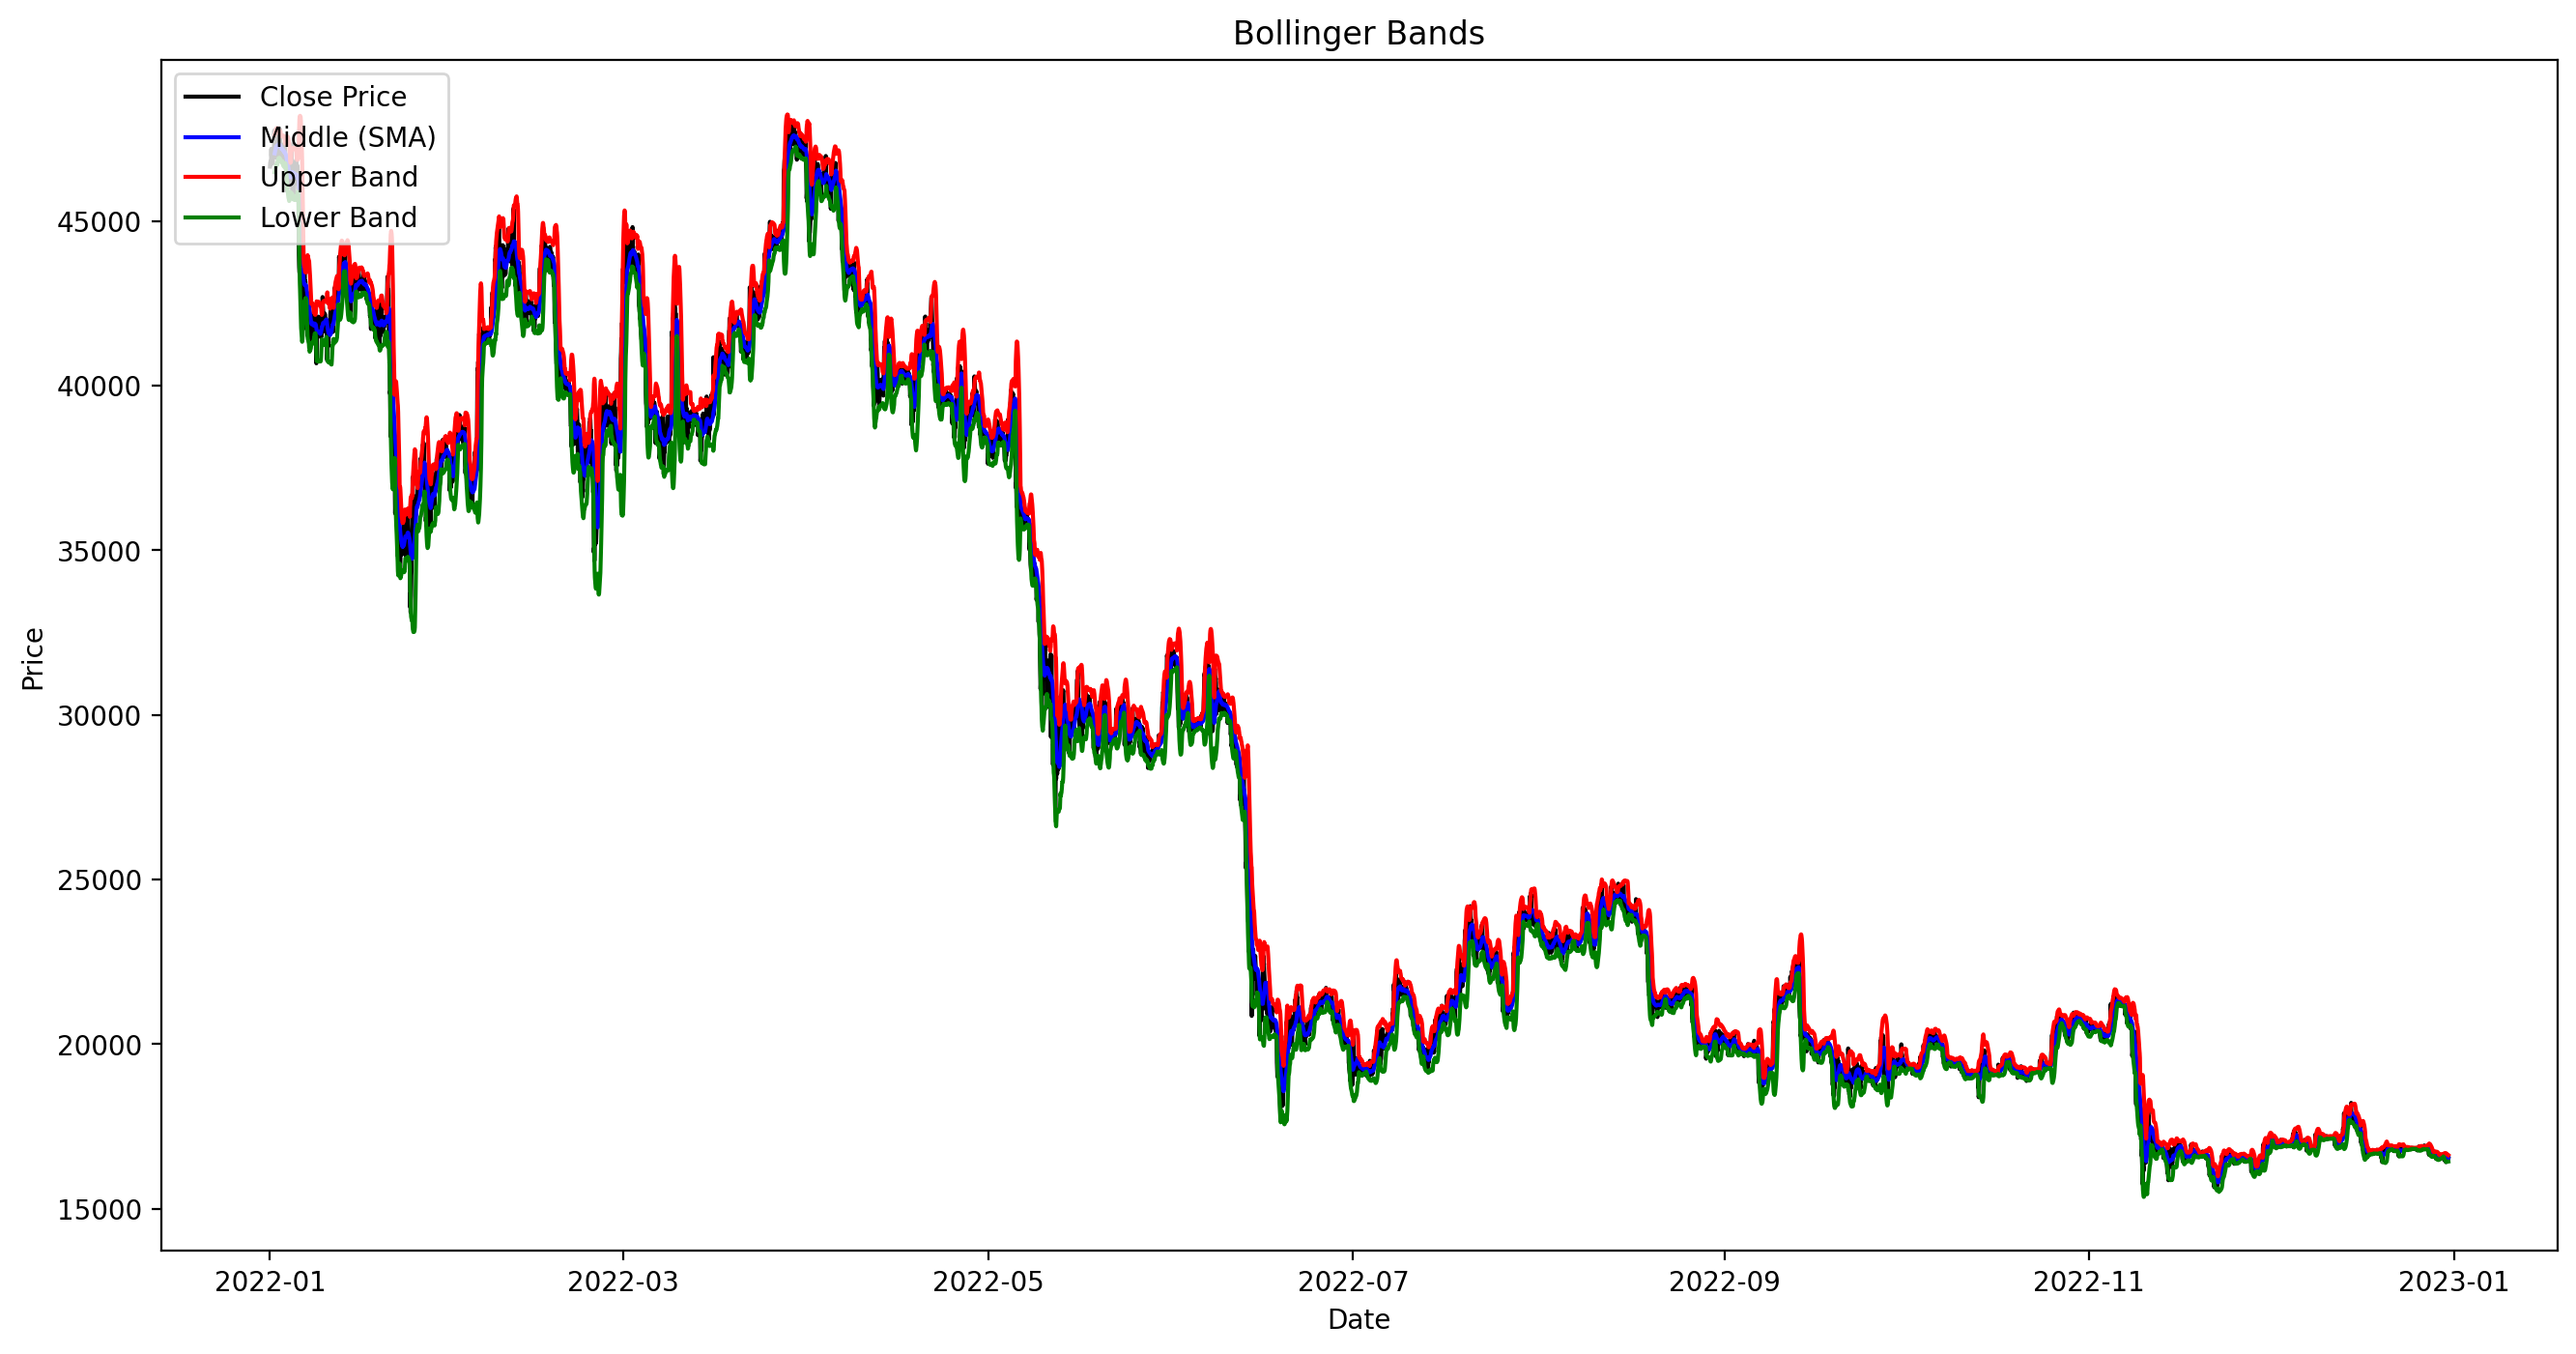

In [18]:
# Plot Bollinger Bands
plt.figure(figsize=(16, 8))
plt.plot(df_btc.index, df_btc['close'], label='Close Price', color='black')
plt.plot(df_btc.index, df_btc['middle'], label='Middle (SMA)', color='blue')
plt.plot(df_btc.index, df_btc['upper'], label='Upper Band', color='red')
plt.plot(df_btc.index, df_btc['lower'], label='Lower Band', color='green')
plt.legend(loc='upper left')
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Our purpose here is to plot the Bollinger Bands, which is a price indicator based on the standard deviation of 
average Bitcoin prices during each time period. Bollinger Bands plots two standard deviations above and below the 
moving average, so 95% of the price changes are likely to be included within the standard deviations. 

We used the plot() function to plot four lines. The black line indicates the closing prices of Bitcoin. The blue 
line indicates the moving average of Bitcoin prices. The red line indicates two standard deviations above the 
moving average. The green line indicates two standard deviations below the moving average. 

When the Bitcoin price is above or below the moving average, the prices are likely to move back toward the moving 
average based on the mean reversion theory and based on probability theory. Therefore, when the price is at the 
lower band, it is a sign to buy Bitcoin. When the price is back at the moving average, investors may sell the 
Bitcoin or they may wait until the price goes up to the upper band, but that would take more time and more risk. 
When the price is at the upper band, that is a sign to sell the Bitcoin. Moreover, trends are important indicators 
as well. If the bands are in the trend of going up, it is a potential up trend. When the bands are going down, it 
is a potential down trend. Therefore, investors may only want to consider buying Bitcoin when the price is at the 
lower band of an upper trend. 

From our graph, we can consider that a good time period to buy Bitcoin is February, March, start of April, middle 
of May, end of July, and the middle of September. We can consider that a good time period to sell Bitcoin is the 
end of January, end of April, start of May, start of June, and start of November. Also, we can see that there is a 
significant down trend over the months. Therefore, we may consider buying at the end of the year and selling at the
beginning of the year. 


In [19]:
# Generate Long/Short Signals based on MACD Crossover
def generate_signals_macd(df):
    df['signal_macd'] = 0.0
    df['signal_macd'] = np.where(df['macd'] > df['signal'], 1.0, 0.0)
    df['positions_macd'] = df['signal_macd'].diff()
    return df

Here we are generating the long signals and short signals of Bitcoin price changes based on MACD Crossover. 
Long signals range from -1.0 to +1.0. A positive signal is an indicator that the prices are bullish, or the belief 
that prices will go up. A negative signal is an indicator that the prices are bearish, or the belief that prices 
will go down. A 0.0 indicates the price is neutral. We will set the signal to 0.0 first. We will select the 
elements where the MCAD value is larger, and select the positive values. Then we will take the difference using 
the diff() function. 

In [20]:
# Generate Long/Short Signals based on BIAS
def generate_signals_bias(df, threshold_Long=-4.5, threshold_sell=7):
    df['signal_bias'] = 0.0
    df['signal_bias'] = np.where(df['bias_12'] < threshold_Long, 1.0, np.where(df['bias_12'] > threshold_sell, -1.0, 0.0))
    df['positions_bias'] = df['signal_bias'].diff()
    return df

We set the long threshold as -4.5 and the sell threshold as 7. We first set the signal bias as 0. We will select 
the data if it is lower than the long threshold, if it is larger than the sell threshold, or 1.0, and 0.0. Then we 
will take the difference between the values using diff(). 


In [21]:
# Generate Long/Short Signals based on RSI
def generate_signals_rsi(df, rsi_lower=30, rsi_upper=70):
    df['signal_rsi'] = 0.0
    df['signal_rsi'] = np.where((df['rsi'] < rsi_lower) & (df['rsi'].shift(1) >= rsi_lower), 1.0, np.where((df['rsi'] > rsi_upper) & (df['rsi'].shift(1) <= rsi_upper), -1.0, 0.0))
    df['positions_rsi'] = df['signal_rsi'].diff()
    return df

We set the lower band of RSI indicator as 30 and the upper band of RSI indicator as 70. We first set the signal 
bias as 0. We select the data if it is lower than the 30 and shift the data by 1 index. We will select the data if 
the data is above 70 and shift the data, or if it’s -1.0 or 0.0. Then we will take the difference between the 
values using diff().

In [22]:
# Generate Long/Short Signals based on Bollinger Bands
def generate_signals_boll(df):
    df['signal_boll'] = 0.0
    df['signal_boll'] = np.where(df['close'] < df['lower'], 1.0, np.where(df['close'] > df['upper'], -1.0, 0.0))
    df['positions_boll'] = df['signal_boll'].diff()
    return df

We first set the signal bias as 0. We select the data if the closing data is lower than the lower band, or if the 
closing data is above the upper band, or if it's -1.0 or 0.0. Then we will take the difference between the values 
using diff().

In [23]:
# Apply Long/Short Signal functions to the dataframe
df_btc = generate_signals_macd(df_btc)
df_btc = generate_signals_bias(df_btc)
df_btc = generate_signals_rsi(df_btc)
df_btc = generate_signals_boll(df_btc)

We apply the long and short signals we just defined to our dataframe. This way, our dataframe consists of all the 
signals generated by various methods, which makes price prediction more accurate. 

In [24]:
# Observe the first few rows of the dataset
df_btc.head()

open      high       low     close      volume  \
timestamp                                                                 
2022-01-01 00:00:00  46216.93  46731.39  46208.37  46656.13  1503.33095   
2022-01-01 01:00:00  46656.14  46949.99  46574.06  46778.14   943.81539   
2022-01-01 02:00:00  46778.14  46928.94  46721.96  46811.77   485.16860   
2022-01-01 03:00:00  46811.77  46916.63  46760.12  46813.20   562.88971   
2022-01-01 04:00:00  46813.21  46887.33  46591.23  46711.05   861.88389   

                            ema12         ema26      macd    signal  bias_12  \
timestamp                                                                      
2022-01-01 00:00:00  46656.130000  46656.130000  0.000000  0.000000      NaN   
2022-01-01 01:00:00  46722.218750  46719.481346  2.737404  1.520780      NaN   
2022-01-01 02:00:00  46757.170624  46752.639763  4.530860  2.754419      NaN   
2022-01-01 03:00:00  46774.856908  46769.569759  5.287149  3.612390      NaN   
2022-01-01 04:00:00  46757.520799  46755.998786  1.522014  2.990550      NaN   

                     ...  upper  lower  signal_macd  positions_macd  \
timestamp            ...                                              
2022-01-01 00:00:00  ...    NaN    NaN          0.0             NaN   
2022-01-01 01:00:00  ...    NaN    NaN          1.0             1.0   
2022-01-01 02:00:00  ...    NaN    NaN          1.0             0.0   
2022-01-01 03:00:00  ...    NaN    NaN          1.0             0.0   
2022-01-01 04:00:00  ...    NaN    NaN          0.0            -1.0   

                     signal_bias  positions_bias  signal_rsi  positions_rsi  \
timestamp                                                                     
2022-01-01 00:00:00          0.0             NaN         0.0            NaN   
2022-01-01 01:00:00          0.0             0.0         0.0            0.0   
2022-01-01 02:00:00          0.0             0.0         0.0            0.0   
2022-01-01 03:00:00          0.0             0.0         0.0            0.0   
2022-01-01 04:00:00          0.0             0.0         0.0            0.0   

                     signal_boll  positions_boll  
timestamp                                         
2022-01-01 00:00:00          0.0             NaN  
2022-01-01 01:00:00          0.0             0.0  
2022-01-01 02:00:00          0.0             0.0  
2022-01-01 03:00:00          0.0             0.0  
2022-01-01 04:00:00          0.0             0.0  

[5 rows x 22 columns]

We will view the first few rows of our dataset after applying the long and short signals. 

In the next cell of code, we calculated the returns for each of the four trading strategies we implemented earlier using different technical indicators.

First, we calculated the daily log returns of the asset by taking the natural logarithm of the closing price divided by the previous day's closing price. 

Next, we calculates the strategy returns for each of the four trading strategies. For each strategy, the strategy returns are calculated as the product of the daily returns and the positions taken by the strategy, which are represented by the positions_ columns that we generated earlier.

For example, for the MACD strategy, the strategy_returns_macd column is calculated by multiplying the daily returns with the positions taken by the MACD strategy, which are represented by the positions_macd column shifted one day forward, using the shift() method to align the positions with the returns for the previous day.

By multiplying the daily returns with the positions, we get the actual returns generated by each strategy, assuming that we take a long position when the strategy generates a buy signal (represented by a value of 1 in the positions column) and a short position when the strategy generates a sell signal (represented by a value of -1 in the positions column).

Finally, the strategy returns are stored in separate columns in the df_btc DataFrame.

In [25]:
# Calculate returns for each strategy
df_btc['returns'] = np.log(df_btc['close'] / df_btc['close'].shift(1))
df_btc['strategy_returns_macd'] = df_btc['returns'] * df_btc['positions_macd'].shift(1)
df_btc['strategy_returns_bias'] = df_btc['returns'] * df_btc['positions_bias'].shift(1)
df_btc['strategy_returns_rsi'] = df_btc['returns'] * df_btc['positions_rsi'].shift(1)
df_btc['strategy_returns_boll'] = df_btc['returns'] * df_btc['positions_boll'].shift(1)

Then we plot the cumulative returns of each trading strategy on a single graph. We plot the cumulative returns of each strategy (MACD, BIAS, RSI, and BOLL) using the cumsum() and apply(np.exp) functions on a 16 by 8 plot. The legend is added to show which line corresponds to which strategy. An axhline is added to represent the baseline returns of 1, and the x-axis and y-axis are labeled. 

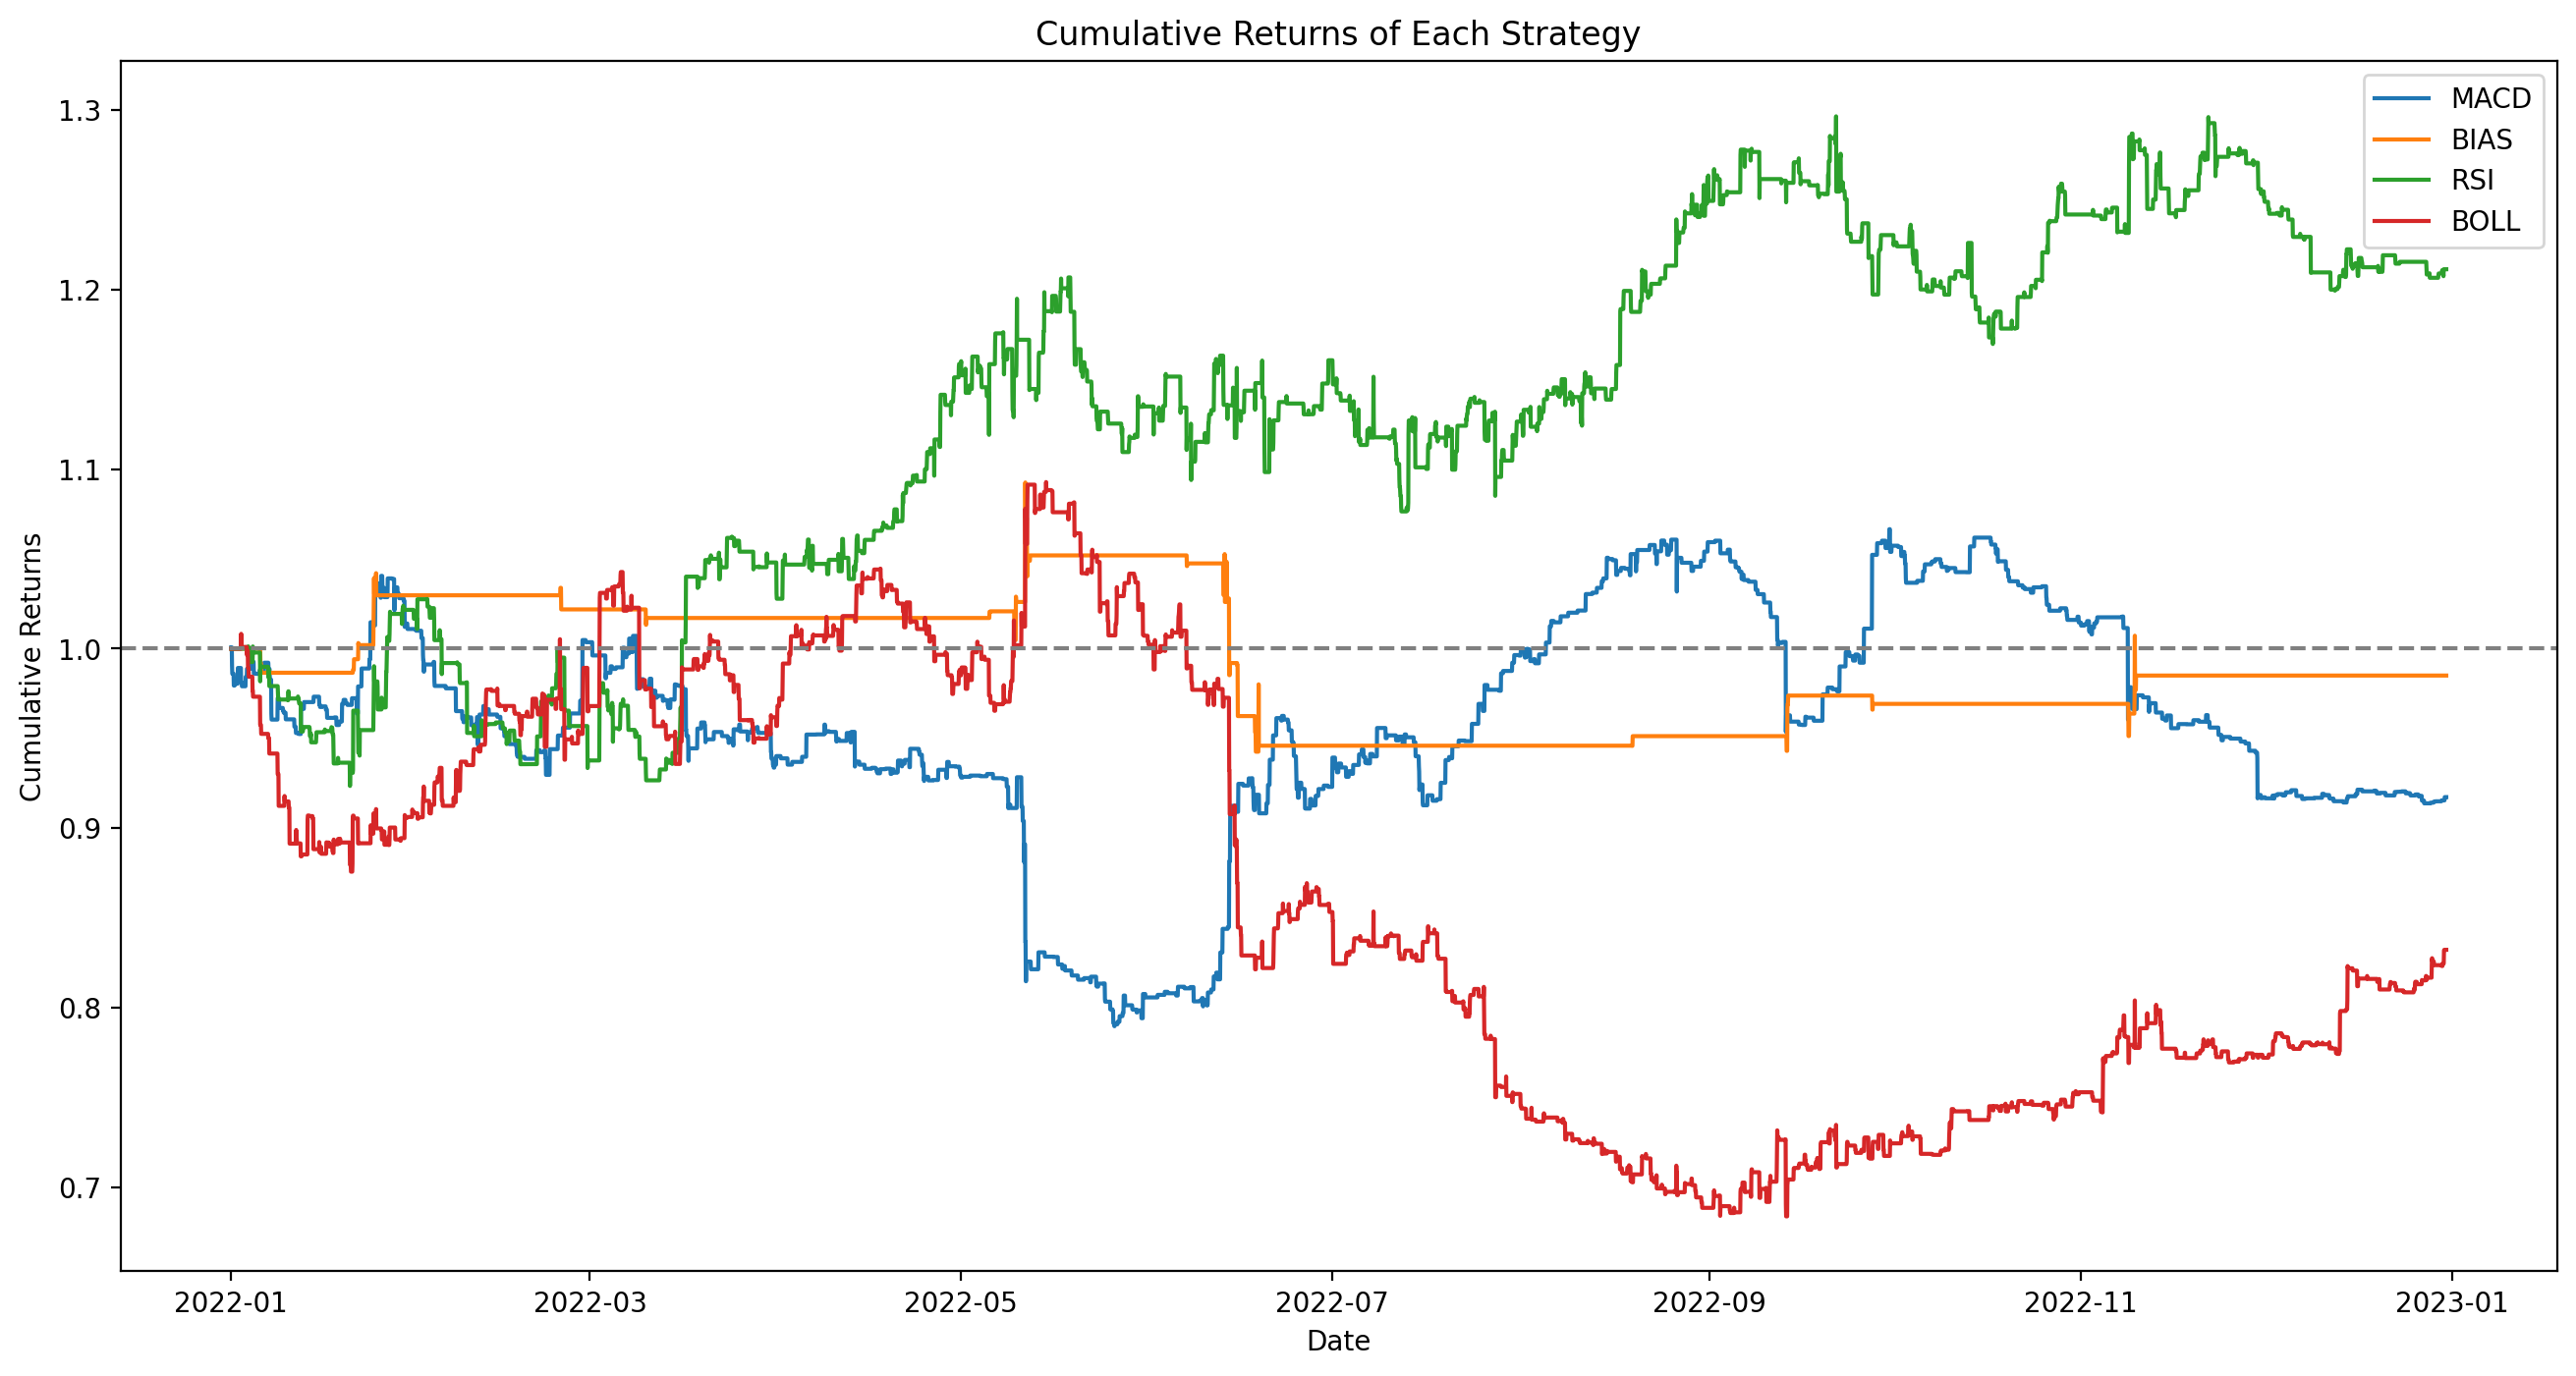

In [26]:
# Plot cumulative returns for each strategy
plt.figure(figsize=(16, 8))
plt.plot(df_btc[['strategy_returns_macd', 'strategy_returns_bias', 'strategy_returns_rsi', 'strategy_returns_boll']].cumsum().apply(np.exp))
plt.legend(['MACD', 'BIAS', 'RSI', 'BOLL'])
plt.axhline(y=1, linestyle='--', color='gray')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Each Strategy')
plt.show()

We can observe that BIAS is not a very strong indicator for BTC, so we drop it. Then we combined the signals from the MACD, RSI, and BOLL indicators to create a final trading signal for the combined strategy. The combined_signal is calculated as the average of the signals from the three indicators, and then is converted into a -1, 0, or 1 position using a threshold value of 0.5. The positions_combined column is created by taking the difference of combined_signal column. Finally, the returns for the combined strategy are calculated using the strategy_returns_combined column by multiplying the returns column by the positions_combined column shifted by one time step.

In [27]:
# Combine signals for a final strategy
df_btc['combined_signal'] = (df_btc['signal_macd'] + df_btc['signal_rsi'] + df_btc['signal_boll']) / 3
df_btc['combined_signal'] = np.where(df_btc['combined_signal'] > 0.5, 1.0, np.where(df_btc['combined_signal'] < -0.5, -1.0, 0.0))
df_btc['positions_combined'] = df_btc['combined_signal'].diff()

# Calculate returns for the combined strategy
df_btc['strategy_returns_combined'] = df_btc['returns'] * df_btc['positions_combined'].shift(1)

We then generated a plot of the cumulative returns for the combined trading strategy. The cumulative returns are calculated by taking the cumulative sum of the product of the daily returns and the positions (long/short) generated by the combined trading strategy. The apply(np.exp) function is used to convert the returns to the exponential scale. The plot shows the performance of the combined strategy over time, with the x-axis representing the dates and the y-axis representing the cumulative returns. The gray dashed line at y=1 represents the initial capital, and any returns above this line indicate a profit, while any returns below this line indicate a loss. The title of the plot indicates that it shows the cumulative returns of each individual strategy as well as the combined strategy.

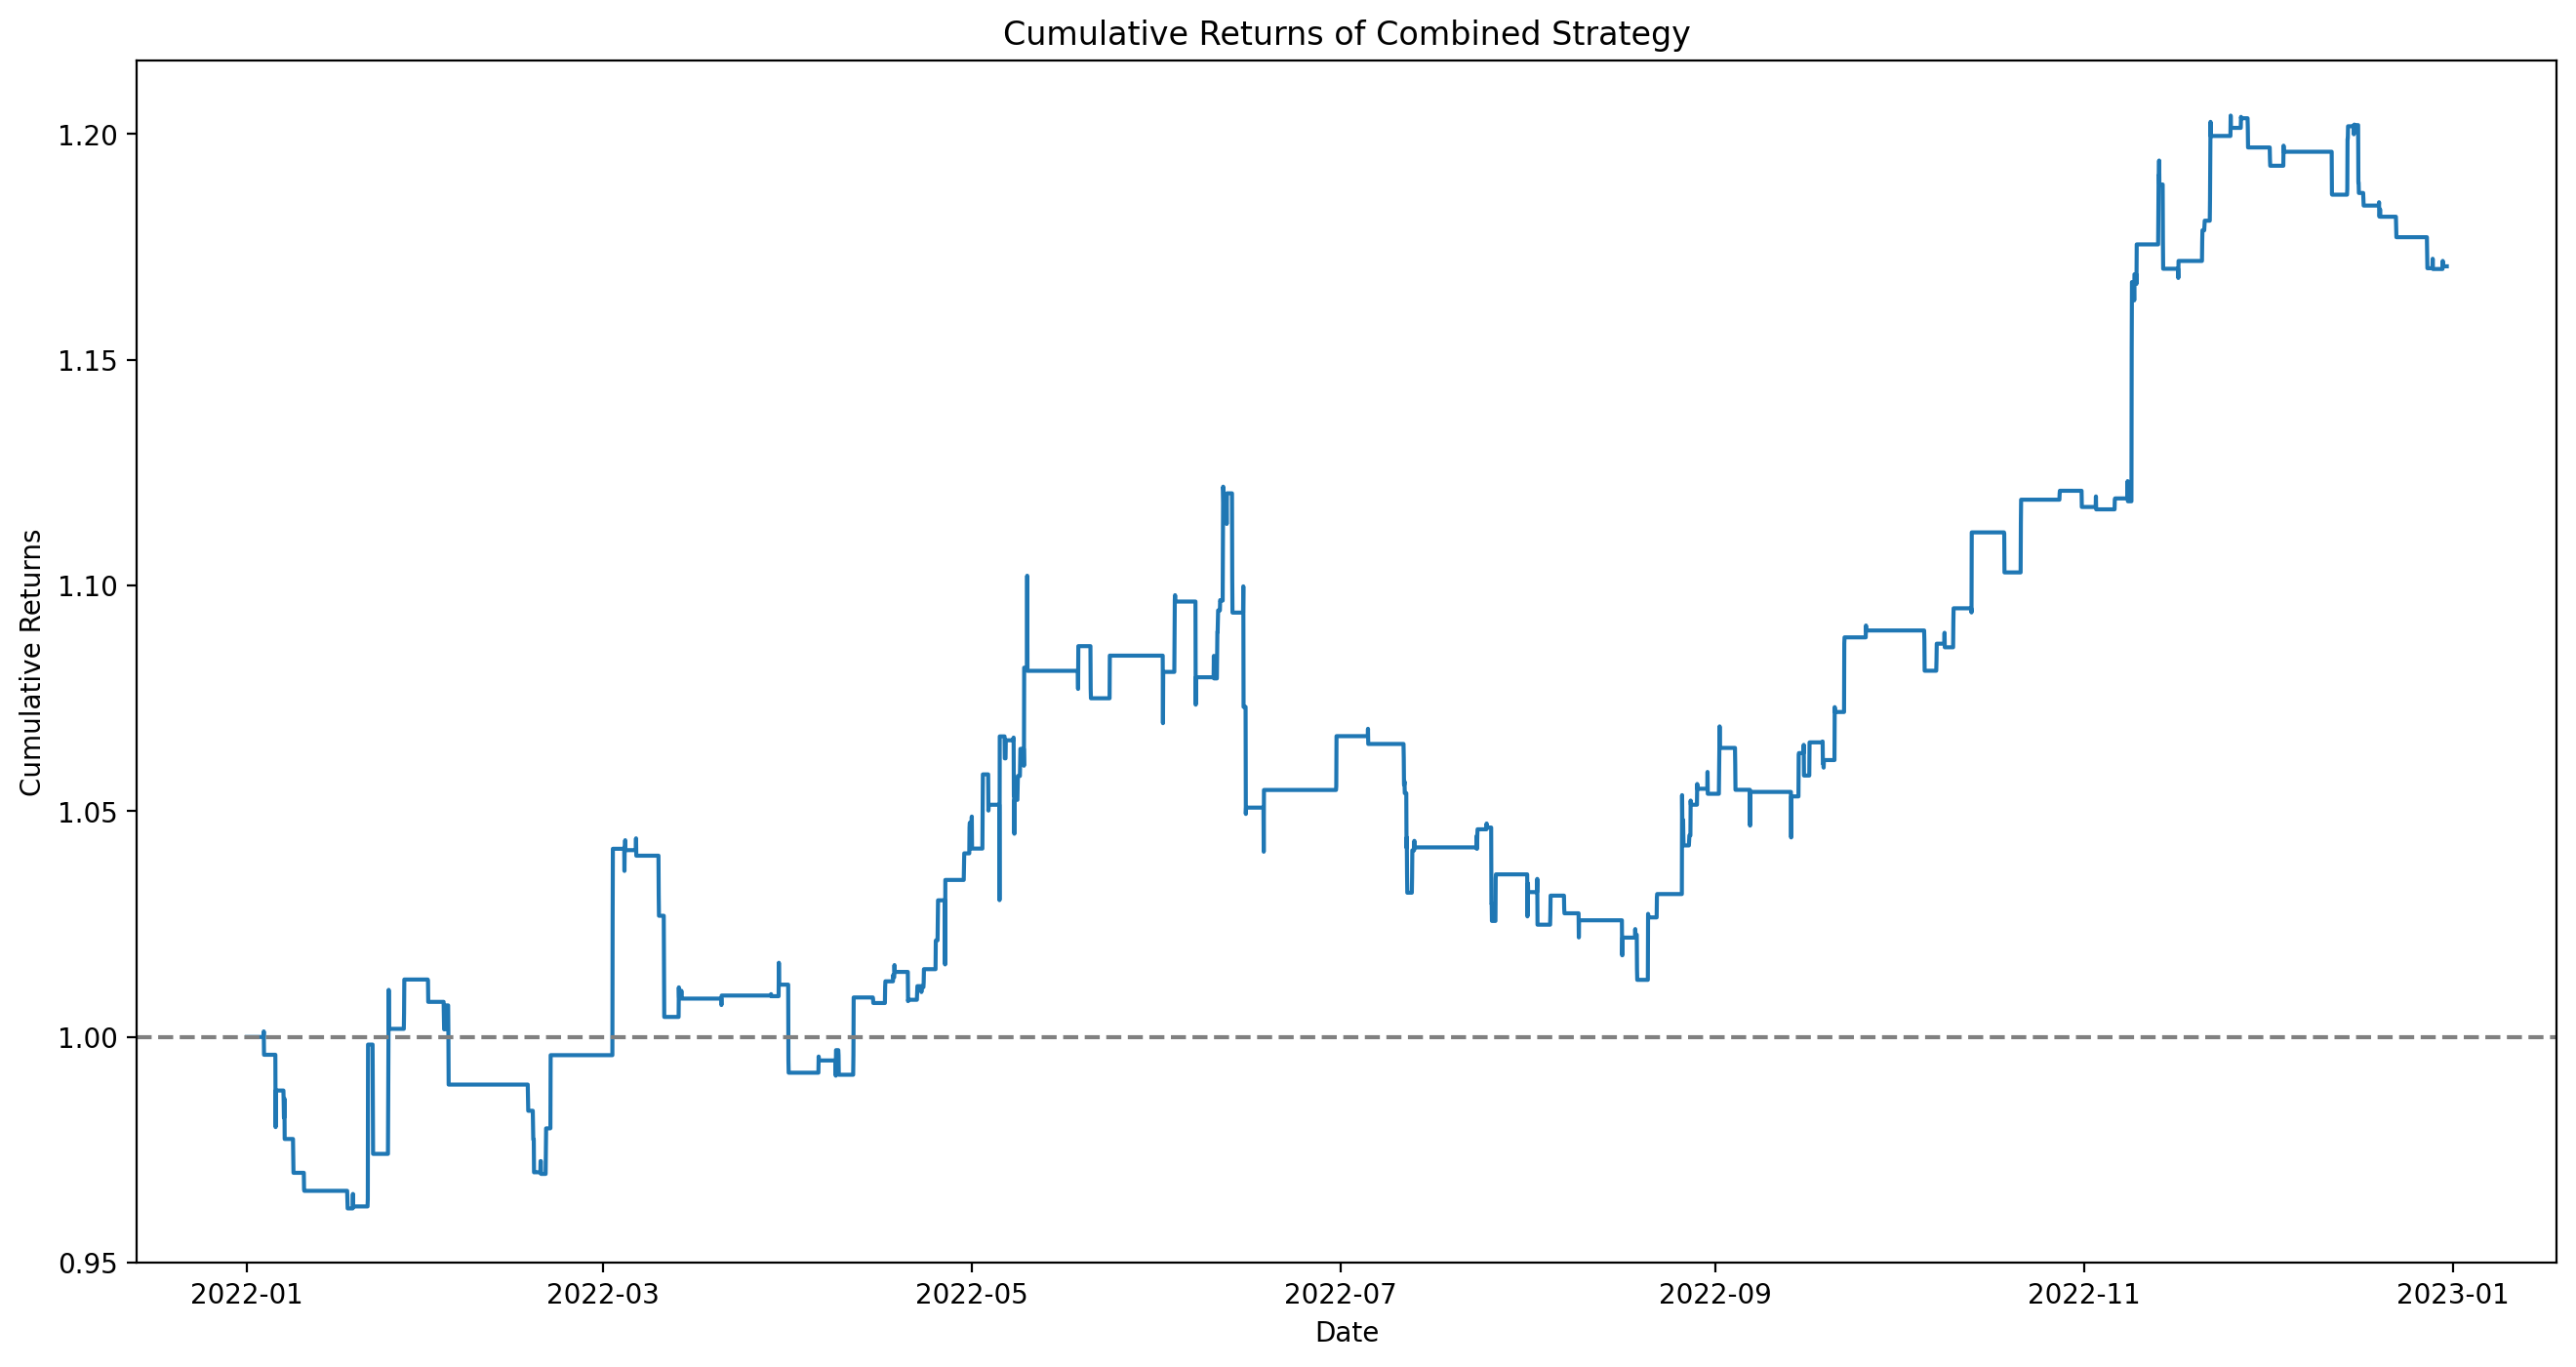

In [28]:
# Plot cumulative returns for the combined strategy
plt.figure(figsize=(16, 8))
plt.plot(df_btc['strategy_returns_combined'].cumsum().apply(np.exp))
plt.axhline(y=1, linestyle='--', color='gray')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Combined Strategy')
plt.show()

Then we check the number of long and short actions taken by the combined strategy. It counts the number of occurrences of each unique value in the 'positions_combined' column of the 'df_btc' DataFrame. A positive value indicates a long position, a negative value indicates a short position, and a zero value indicates no position.

In [29]:
# Check the number of Long/Short actions
df_btc['positions_combined'].value_counts()

 0.0    8406
 1.0     165
-1.0     165
Name: positions_combined, dtype: int64

We then print the final return of the combined strategy. It calculates the cumulative returns of the combined strategy using cumsum() and then apply the exponential function to transform the cumulative returns to the final return. The final return is the value of the last element in the transformed cumulative returns array.

In [30]:
# Check the final return
print('The final return:', df_btc['strategy_returns_combined'].cumsum().apply(np.exp)[-1])

The final return: 1.1707152903818603


Lastly, we check the highest return achieved by the combined strategy by using the pandas sort_values() method to sort the cumulative returns of the combined strategy in descending order and then return the first element in the resulting series, which corresponds to the highest cumulative return achieved.

In [31]:
# Check the highest return
print('The highest return:', df_btc['strategy_returns_combined'].cumsum().apply(np.exp).sort_values(ascending=False)[0])

The highest return: 1.2041080057695603


Similarly, we check the lowest return by sorting in ascending order and retuning the first element in the result. 

In [32]:
# Check the lowest return
print('The lowest return:', df_btc['strategy_returns_combined'].cumsum().apply(np.exp).sort_values(ascending=True)[0])

The lowest return: 0.962037456634262


Since the final profit is much greater than 1, we can conclude that traditional financial indicators can be used to predict the price of Bitcoin.